In [764]:
#Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [765]:
#Grab Data from necessary places
stat_info = []
betting_info = []
recruiting = np.load("./Data/Stored NPs/recruiting.npy")
game_info = np.load("./Data/Stored NPs/game_info.npy")
teams = np.loadtxt("./Data/teams.csv",dtype='str',delimiter=', ',ndmin=2)

recruiting_means = np.load("./Data/Stored NPs/recruiting_means.npy")
recruiting_stds = np.load("./Data/Stored NPs/recruiting_stds.npy")
stat_means = np.load("./Data/Stored NPs/stat_means.npy")
stat_stds = np.load("./Data/Stored NPs/stat_stds.npy")

for team in range(len(teams)):
    file_ref = "./Data/Stored NPs/Stats/team_{}.npy".format(team)
    stat_info.append(np.load(file_ref))
    file_ref = "./Data/Stored NPs/Spreads/team_{}.npy".format(team)
    betting_info.append(np.load(file_ref))
                    
print(stat_info[0][50:53,:])

[[ 3.52000000e-01  1.00000000e+00  1.76762489e+00  2.52065097e+00
  -1.34456147e+00 -1.83926479e+00 -1.14250069e+00  2.35780965e+00
  -9.57653025e-01  8.62648882e-01 -1.75392921e+00 -1.29078161e+00
  -9.66820110e-02 -5.35823305e-01  7.32401172e-02  1.89625542e-01
   9.49884233e-01 -1.12500004e+00 -4.92225908e-01  1.65381091e-01
   1.47650690e-01 -3.96168860e-01 -4.83339633e-02  1.89625542e-01
  -4.80768710e-01  3.00428188e-01  2.00500000e+03  9.90000000e+01]
 [ 4.08000000e-01  1.00000000e+00  9.04059076e-01  1.64108960e+00
  -7.99269605e-01 -9.08235159e-01 -1.00741838e+00 -8.94466511e-01
   9.49884233e-01 -9.54630129e-01  6.90971407e-01  3.70612076e-01
   1.06730639e+00  2.27944755e-02  4.78487052e-01 -8.94466511e-01
  -9.57653025e-01  1.20338870e+00 -3.94654186e-01  3.11974652e-01
   1.18288820e-01  4.04516626e-01  5.69896135e-03  4.06443952e-01
   9.49884233e-01 -2.61792506e-01  2.00500000e+03  8.70000000e+01]
 [ 4.64000000e-01  0.00000000e+00  4.66668599e-01 -2.03040858e-02
   5.744

In [766]:
num_games = 12
num_rec = 4

In [767]:
def stat_search(info):
    
    stats = np.zeros((num_games,50))
    
    #Pick out stats from the last 10 games for the visitor
    visitor_stats = stat_info[int(info[0])]
    iterator = -1
    done = False
    
    while not done:
        iterator += 1
        
        if iterator == len(visitor_stats):
            return stats, True
        
        curr_game = visitor_stats[iterator]
        if info[2] == curr_game[26]:
            if info[3] == curr_game[0]:
                done = True
    
    stats[:,0:25] =  visitor_stats[iterator-num_games:iterator,1:26]
    
    #Pick out stats from the last 10 games for the home team
    home_stats = stat_info[int(info[1])]
    iterator = -1
    done = False
    
    while not done:
        iterator += 1
        
        if iterator == len(home_stats):
            return stats, True
        
        curr_game = home_stats[iterator]
        if info[2] == curr_game[26]:
            if info[3] == curr_game[0]:
                done = True
    stats[:,25:50] =  home_stats[iterator-num_games:iterator,1:26]
    
    return stats, False

In [768]:
def recruiting_search(info):
    
    curr_row = int(info[2]-2000)
    curr_recruits = np.zeros((num_rec,12))
    
    curr_recruits[:,:6] = recruiting[int(info[0]),(curr_row-num_rec+1):curr_row+1]
    curr_recruits[:,6:] = recruiting[int(info[1]),(curr_row-num_rec+1):curr_row+1]
    
    return curr_recruits

In [769]:
#Store into usable data
#Unit of Input Data
#[[Data],[Scores]]
#Data = [[Stats],[Recruiting],Day_scalar]
#Scores = [Score_differential,spread,O/U]


training_set = []
test_set = []
incon = 0

for game in game_info:
    
    data_item = []
    stats, not_found = stat_search(game)
    
    if not not_found:
        data_item.append(stats)
        data_item.append(recruiting_search(game))
        data_item.append(np.array(game[3]))

        score_item = game[4:]
        item = [data_item,score_item]

        #If season is before 2016, training set
        if game[2] < 2015:
            training_set.append(item)
        else:
            #test set is 2015 - 2017
            test_set.append(item)
    else:
        incon += 1
    


In [770]:
print(recruiting.shape)
print(incon)
print(len(training_set))
print(len(test_set))

(113, 18, 6)
6
7684
1838


In [1305]:
test_act = 0
test_range = []

for i in range(len(test_set)):
    test_range.append(test_set[i][1][0])
    
print( sum(abs(test_range - np.mean(test_range)))/ len(test_set))

16.8344944888528


In [771]:
# Use if running on a GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

In [1320]:
iterations = 6000
batch_size = 50

stats_scale_down = 10

In [773]:
print(training_set[:2])

[[[array([[ 1.00000000e+00,  3.56204736e+00,  3.49794137e+00,
        -1.85839419e+00, -2.21167665e+00, -1.81791225e+00,
        -8.94466511e-01, -9.57653025e-01,  1.43054857e+00,
        -1.31653873e+00, -1.09532353e+00, -4.63705381e-01,
         3.95206329e-01,  7.32401172e-02,  1.89625542e-01,
        -9.57653025e-01, -1.35215991e+00,  9.64620834e-01,
         1.25017344e+00,  2.29444469e-01, -7.03084879e-02,
        -7.53504256e-02, -3.52420484e-01, -1.94638122e-01,
         7.20673959e-01,  1.00000000e+00, -5.87554602e-01,
         5.66070157e-01, -5.79055583e-01,  3.02103366e-01,
        -3.32006818e-01,  5.61008580e+00, -3.88439605e-03,
        -1.59570562e-01,  1.75074948e-01,  1.05471536e+00,
         4.48609853e-01, -6.28926268e-01, -6.02171441e-01,
         1.89625542e-01, -9.57653025e-01,  1.20338870e+00,
        -7.96156214e-01, -5.08949288e-01,  2.39930851e-01,
         1.90379810e-01, -6.18421945e-02,  1.27371759e+00,
         9.14924668e-02, -2.32746358e-02],
       [ 1

In [824]:
def data_batch(data,size):
    samples = np.random.choice(len(data),size,replace=False)
    
    stats = []
    recruits = []
    scalar = []
    margin = []
    for sample in samples:
        stats.append(np.asarray(data[sample][0][0]))
        recruits.append(np.asarray(data[sample][0][1]))
        scalar.append(np.expand_dims(data[sample][0][2], axis = 1))
        margin.append(np.asarray(data[sample][1][:2]))
    
    return samples, {statistics: stats,
            recruiting: recruits,
            day_scalar: scalar,
            targets: margin}

In [825]:
# Reset the graph
tf.reset_default_graph()
tf.set_random_seed(2018)

# Placeholders
statistics = tf.placeholder(tf.float32, [None, num_games, 50])
recruiting = tf.placeholder(tf.float32, [None, num_rec, 12])
targets = tf.placeholder(tf.float32, [None, 2])
day_scalar = tf.placeholder(tf.float32, [None, 1])

vec1 = tf.layers.flatten(statistics)
vec2 = tf.layers.flatten(recruiting)
all_vec = tf.concat([vec1,vec2],1)

out_l1 = tf.layers.dense(all_vec,50,activation=None, name='Lay1')
output = tf.layers.dense(out_l1,2,activation=None, name='Lay2')
'''

#Row densely connect the stats 
conn_stats = tf.layers.dense(statistics,12,use_bias=True,activation=None, name='S_conn')
#Get our flat vector results
flat_stats = tf.layers.flatten(conn_stats)
flat_stats = tf.layers.dense(flat_stats, 24,use_bias=True,activation=None, name='S_conn2')
print(flat_stats.shape)
#Get our convolutional results
conn_stats = tf.reshape(conn_stats,[-1,num_games,12,1])
conv_stats = tf.layers.conv2d(conn_stats, 6, [5,12], padding='SAME', use_bias=True, activation=tf.nn.relu, name='S_conv')
pool_stats = tf.layers.average_pooling2d(conv_stats, [1,12], strides=[1,1], name='S_pool')
pool_stats = tf.layers.flatten(pool_stats)
print(pool_stats.shape)

#Row densely connect recruiting
conn_rec = tf.layers.dense(recruiting,6,use_bias=True,activation=None, name='R_conn')
#Get flat vector results
flat_rec = tf.layers.flatten(conn_rec)
flat_rec = tf.layers.dense(flat_rec, 12,use_bias=True,activation=None, name='R_conn2')
print(flat_rec.shape)
#Get our convolutional results
conn_rec = tf.reshape(conn_rec,[-1,num_rec,6,1])
conv_rec = tf.layers.conv2d(conn_rec, 6, [3,6], padding='SAME',use_bias=True,activation=tf.nn.relu, name='R_conv')
pool_rec = tf.layers.average_pooling2d(conv_rec, [1,6], strides=[1,1], name='R_pool')
pool_rec = tf.layers.flatten(pool_rec)
print(pool_rec.shape)

#Connect all of our information togethor
all_vec = tf.concat([flat_stats,pool_stats,flat_rec,pool_rec,day_scalar],1)
all_vec = tf.layers.dense(all_vec, 40,use_bias=True,activation=None, name="FC_lay1")
output = tf.layers.dense(all_vec, 2,use_bias=True,activation=None, name="FC_lay2")
'''
loss = tf.reduce_mean(tf.abs(output-targets))

train_step = tf.train.AdamOptimizer(.0001).minimize(loss)

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # This is added back by InteractiveShellApp.init_path()


0.0
0.16666666666666666
0.3333333333333333
0.5
0.6666666666666666
0.8333333333333334
1.0


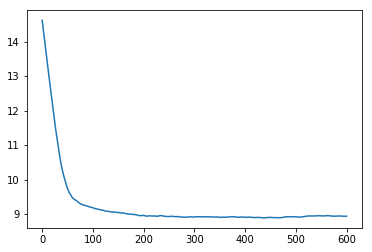

In [826]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

test_loss = []
store = []

for i in range(iterations+1):
    _, batch = data_batch(training_set,batch_size)
    sess.run(train_step, feed_dict=batch)
    
    if i%10 == 0:
        samps, test_data = data_batch(test_set,len(test_set))
        test_loss.append(sess.run(loss, feed_dict=test_data))
    if i%1000 == 0:
        print(i/iterations)
        if i > 6500:
            store.append([samps,sess.run(output, feed_dict=test_data)])
        
plt.plot(test_loss)

In [827]:
samps, all_test = data_batch(test_set,len(test_set))
test_results = sess.run(output, feed_dict=all_test)
sess.close()

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # This is added back by InteractiveShellApp.init_path()


In [828]:
num_samps = len(samps)

pred_sp_sp = 0
pred_sp_ac = 0
pred_ac_sp = 0
pred_ac_ac = 0
sp_ac = 0

for ind in range(num_samps):
    get_act = test_set[samps[ind]][1][:2]
    
    pred_ac_ac += abs(test_results[ind,0] - get_act[0])/num_samps
    pred_ac_sp += abs(test_results[ind,0] - get_act[1])/num_samps
    pred_sp_ac += abs(test_results[ind,1] - get_act[0])/num_samps
    pred_sp_sp += abs(test_results[ind,1] - get_act[1])/num_samps
    sp_ac += abs(get_act[1] - get_act[0])/num_samps
    
print(pred_sp_sp)
print(pred_sp_ac)
print(pred_ac_sp)
print(pred_ac_ac)
print(sp_ac)

4.47287279345558
13.227933128564016
5.261017861041332
13.403116429802253
12.547878128400514


In [1332]:
samples = np.random.choice(len(data),size,replace=False)

In [1333]:
# Reset the graph
tf.reset_default_graph()
tf.set_random_seed(2018)

# Placeholders
statistics = tf.placeholder(tf.float32, [None, num_games, 50])
recruiting = tf.placeholder(tf.float32, [None, num_rec, 12])
oth_vals = tf.placeholder(tf.float32, [None, 3])
target = tf.placeholder(tf.float32, [None, 1])

# 1D flattens
cond_stats = tf.layers.dense(statistics,6,activation=None, name='stat1D')
flat_stats = tf.layers.flatten(cond_stats)
cond_rec = tf.layers.dense(recruiting,4,activation=None, name='rec1D')
flat_cond = tf.layers.flatten(cond_rec)

#FCC layers for predictions
all_vec = tf.concat([flat_stats,flat_cond,oth_vals],1)
up_down = tf.layers.dense(all_vec,16,activation=tf.nn.sigmoid, name='up_down1')
up_down = tf.layers.dense(up_down,1,activation=tf.nn.sigmoid, name='up_down2')

dir_loss = -tf.reduce_mean(tf.log(1-tf.abs(up_down-target)))
dir_step = tf.train.AdamOptimizer(.0001).minimize(dir_loss)

#Get actual accuracy for predictions
prediction = tf.cast(tf.round(up_down),tf.bool)
target_act = tf.cast(tf.round(target),tf.bool)
correct_pred = tf.logical_not(tf.logical_xor(prediction,target_act))
accuracy = tf.div(tf.reduce_sum(tf.to_float(correct_pred)),tf.to_float(tf.size(target)))

conf_vec = tf.concat([all_vec,up_down,tf.to_float(prediction)],1)
conf = tf.layers.dense(conf_vec,16,activation=tf.nn.sigmoid, name='conf1')
conf = tf.layers.dense(conf,1,activation=tf.nn.sigmoid, name='conf2')

conf_loss = -tf.reduce_mean(tf.log(tf.abs(conf-tf.to_float(correct_pred))))
conf_step = tf.train.AdamOptimizer(.0001).minimize(conf_loss)

In [1334]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

test_vals = []

for i in range(iterations):
    _, batch = bet_batch(training_set,batch_size)
    sess.run(dir_step, feed_dict=batch)
    sess.run(conf_step, feed_dict=batch)
    
    if i%20 == 0:
        _, test_data = bet_batch(test_set,len(test_set))
        test_vals.append(sess.run([dir_loss,accuracy,conf_loss], feed_dict=test_data))
    if i%1000 == 0:
        print(i/iterations)

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()
C:\Users\Zenaardvark\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  
C:\Users\Zenaardvark\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0.0
0.16666666666666666
0.3333333333333333
0.5
0.6666666666666666
0.8333333333333334


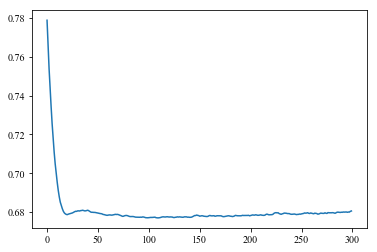

In [1335]:
plt.plot([x[0] for x in test_vals])
#plt.plot(test_vals[:][1])
#plt.plot(test_vals[:][2])

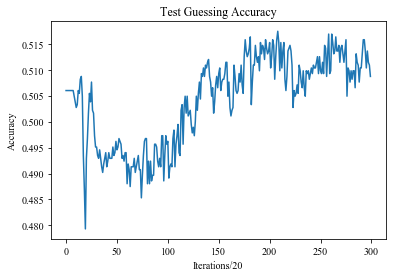

In [1340]:
plt.plot([x[1] for x in test_vals])
csfont = {'fontname':'Times New Roman'}
plt.title('Test Guessing Accuracy', **csfont)
plt.xlabel('Iterations/20')
plt.ylabel('Accuracy')
plt.savefig("false_accuracy.png",dpi=300)

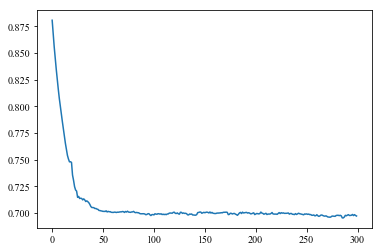

In [1337]:
plt.plot([x[2] for x in test_vals])

In [1338]:
#Let's get our final values
num_vals = len(test_set)

_, test_data = bet_batch(test_set,num_vals)
final_vals = sess.run([up_down,correct_pred,conf], feed_dict=test_data)

dependent_conf = np.asarray(1 - abs(final_vals[0]-0.5)).flatten()
independent_conf = np.asarray(final_vals[2]).flatten()

dependent_money = []
independent_money = []

#for curr_len in range(num_vals):
for curr_size in range(num_vals):
    
    dependent_conf_ind = np.argpartition(dependent_conf,range(num_vals))[:curr_size]
    independent_conf_ind = np.argpartition(independent_conf,range(num_vals))[:curr_size]
    
    dependent_corr = sum(final_vals[1][dependent_conf_ind])
    dependent_money.append(dependent_corr*100 + (curr_size-dependent_corr)*(-110))
    independent_corr = sum(final_vals[1][independent_conf_ind])
    independent_money.append(independent_corr*100 + (curr_size-independent_corr)*(-110))

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  
C:\Users\Zenaardvark\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()
C:\Users\Zenaardvark\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


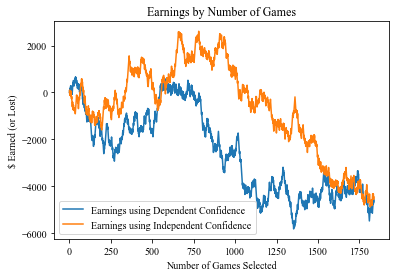

In [1339]:
plt.plot(dependent_money, label='Earnings using Dependent Confidence')
plt.plot(independent_money, label='Earnings using Independent Confidence')
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()
plt.ylabel('$ Earned (or Lost)')
plt.xlabel('Number of Games Selected')
plt.title('Earnings by Number of Games')
plt.savefig("prop_earnings2.png",dpi=300)

In [1043]:
curr_array = np.asarray(final_vals[2]).flatten()
top = np.argpartition(curr_array,range(num_vals))[-50:]
bot = np.argpartition(curr_array,range(num_vals))[:50]

print(1-final_vals[2])
print(sum(final_vals[1][top]))
print(sum(final_vals[1][bot]))

[[0.9987635 ]
 [0.84062874]
 [0.9590496 ]
 ...
 [0.67542243]
 [0.73097616]
 [0.8678892 ]]
[26]
[50]


In [1331]:
sess.close()